In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
from torchsummary import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
import os
from utils.datasets import DatasetLoader
from models.CAM_based_models import MTEXCNN
from models.CAM_based_models import XCM
from utils.training import train_model
from feature_extraction.CAM import GradCAM

# Load data

In [2]:
# Load dataset

dataset_path = './data/UWaveGestureLibrary'
dataset = DatasetLoader(dataset_path)
train_data, test_data = dataset.load_to_df()

In [3]:
X_train, y_train, X_test, y_test = dataset.load_to_nparray()

In [4]:
display(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 3, 315)

(120,)

(320, 3, 315)

(320,)

## Create DataLoader

In [5]:
dataloaders, datasets_size = dataset.get_torch_dataset_loader_auto(4, 4)

# CAM-based models

## MTEX-CNN

In [6]:
net = MTEXCNN(X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net

MTEXCNN(
  (cnn_layers): Sequential(
    (conv_1): Conv2d(1, 16, kernel_size=(158, 1), stride=(1, 1))
    (relu_1): ReLU(inplace=True)
    (conv_2): Conv2d(16, 32, kernel_size=(79, 1), stride=(1, 1))
    (relu_2): ReLU(inplace=True)
    (conv_3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_3): ReLU(inplace=True)
    (reshape): Reshape()
    (conv_4): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
    (relu_4): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (fc1): Linear(in_features=4992, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [7]:
summary(net, (1,315,3))

[-1, 3, 80]
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 158, 3]           2,544
              ReLU-2           [-1, 16, 158, 3]               0
            Conv2d-3            [-1, 32, 80, 3]          40,480
              ReLU-4            [-1, 32, 80, 3]               0
            Conv2d-5             [-1, 1, 80, 3]              33
              ReLU-6             [-1, 1, 80, 3]               0
           Reshape-7                [-1, 3, 80]               0
            Conv1d-8               [-1, 64, 78]             640
              ReLU-9               [-1, 64, 78]               0
           Linear-10                   [-1, 32]         159,776
           Linear-11                    [-1, 8]             264
Total params: 203,737
Trainable params: 203,737
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0

## XCM

In [8]:
window_size = int(0.3*X_train.shape[2])
if window_size % 2 == 0:
    window_size -= 1

net1 = XCM(window_size, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
net1

XCM(
  (conv_11): Conv2d(1, 16, kernel_size=(93, 93), stride=(1, 1), padding=(46, 46))
  (batchnorm_11): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_12): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
  (conv_21): Conv1d(3, 16, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_21): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_22): Conv1d(16, 1, kernel_size=(1,), stride=(1,))
  (conv_3): Conv1d(315, 32, kernel_size=(93,), stride=(1,), padding=(46,))
  (batchnorm_3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (glb_avg_pool): AvgPool1d(kernel_size=(4,), stride=(4,), padding=(0,))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=32, out_features=8, bias=True)
  (softmax): Softmax(dim=1)
)

In [9]:
summary(net1, (1,315,3))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 315, 3]         138,400
       BatchNorm2d-2           [-1, 16, 315, 3]              32
            Conv2d-3            [-1, 1, 315, 3]              17
            Conv1d-4              [-1, 16, 315]           4,480
       BatchNorm1d-5              [-1, 16, 315]              32
            Conv1d-6               [-1, 1, 315]              17
            Conv1d-7                [-1, 32, 4]         937,472
       BatchNorm1d-8                [-1, 32, 4]              64
         AvgPool1d-9                [-1, 32, 1]               0
          Flatten-10                   [-1, 32]               0
           Linear-11                    [-1, 8]             264
          Softmax-12                    [-1, 8]               0
Total params: 1,080,778
Trainable params: 1,080,778
Non-trainable params: 0
---------------------------

# Training

In [10]:
# from torch_lr_finder import LRFinder

# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
# criterion = nn.CrossEntropyLoss()
# optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-6)

# lr_finder = LRFinder(model.double(), optimizer_ft, criterion)
# lr_finder.range_test(dataloaders['train'], val_loader=dataloaders['val'], end_lr=1e-3, num_iter=100, step_mode="exp")
# lr_finder.plot() # to inspect the loss-learning rate graph
# lr_finder.reset() # to reset the model and optimizer to their initial state

Epoch 0/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 1.9908 Acc: 0.2167 Correct: 26.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 8

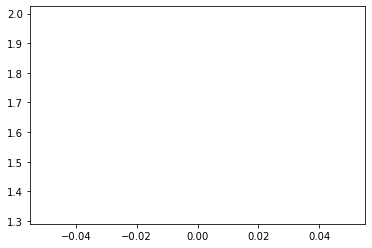

Epoch 1/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 1.2224 Acc: 0.5333 Correct: 64.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 8

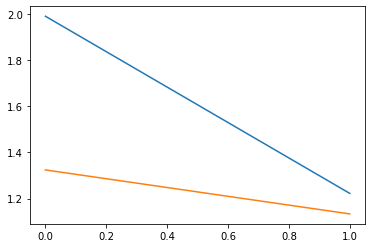

Epoch 2/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 1.0015 Acc: 0.6667 Correct: 80.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 8

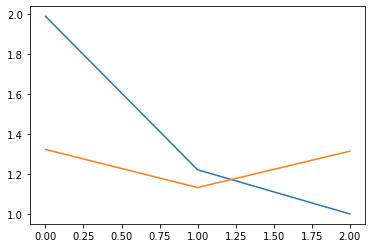

Epoch 3/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.8093 Acc: 0.7500 Correct: 90.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 8

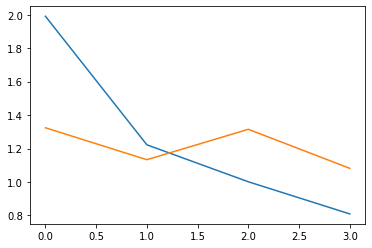

Epoch 4/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.7380 Acc: 0.7417 Correct: 89.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 8

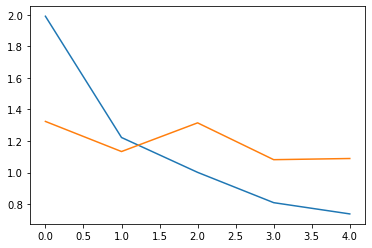

Epoch 5/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.5460 Acc: 0.8333 Correct: 100.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 

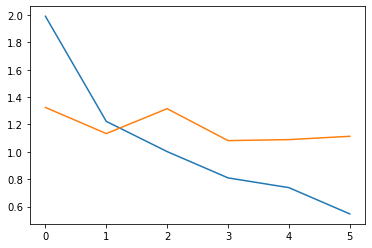

Epoch 6/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.5281 Acc: 0.8083 Correct: 97.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 8

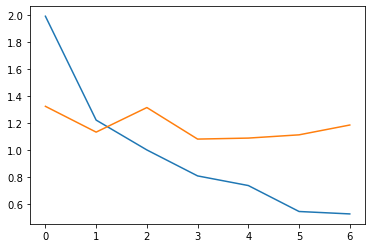

Epoch 7/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.3651 Acc: 0.9083 Correct: 109.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 

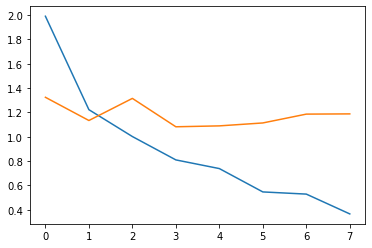

Epoch 8/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.3593 Acc: 0.8667 Correct: 104.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 

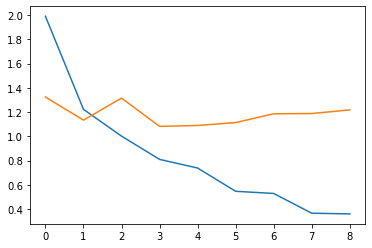

Epoch 9/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.3396 Acc: 0.9083 Correct: 109.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 

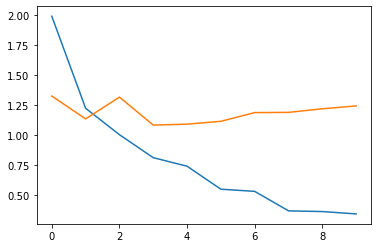

Epoch 10/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1976 Acc: 0.9500 Correct: 114.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

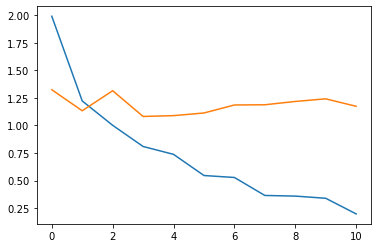

Epoch 11/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1777 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

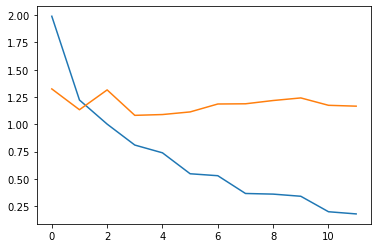

Epoch 12/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1639 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

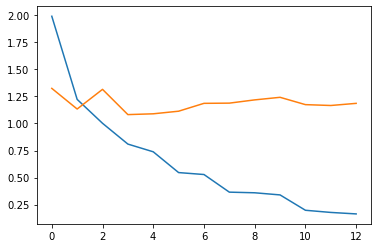

Epoch 13/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1583 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

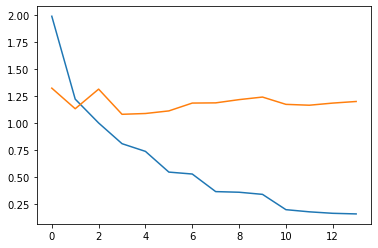

Epoch 14/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1525 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

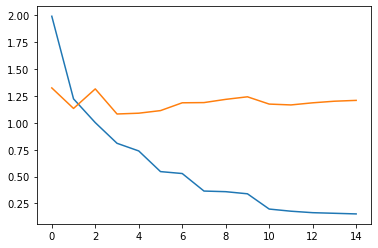

Epoch 15/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1507 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

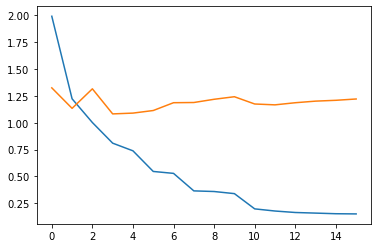

Epoch 16/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1449 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

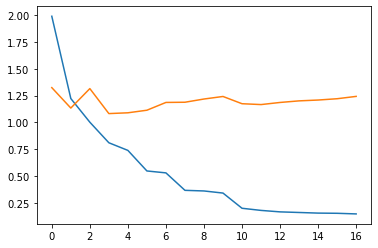

Epoch 17/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1396 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

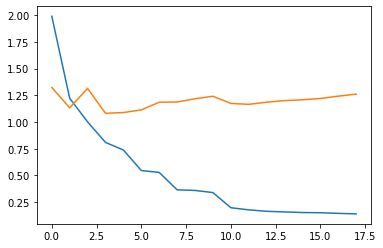

Epoch 18/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1360 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

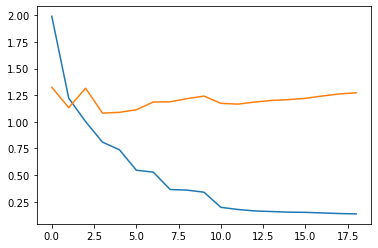

Epoch 19/19
----------
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
train Loss: 0.1325 Acc: 0.9667 Correct: 116.0
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3, 80]
[-1, 3,

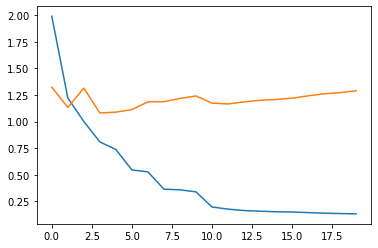

Training complete in 0m 19s
Best val Acc: 0.715625


MTEXCNN(
  (cnn_layers): Sequential(
    (conv_1): Conv2d(1, 16, kernel_size=(158, 1), stride=(1, 1))
    (relu_1): ReLU(inplace=True)
    (conv_2): Conv2d(16, 32, kernel_size=(79, 1), stride=(1, 1))
    (relu_2): ReLU(inplace=True)
    (conv_3): Conv2d(32, 1, kernel_size=(1, 1), stride=(1, 1))
    (relu_3): ReLU(inplace=True)
    (reshape): Reshape()
    (conv_4): Conv1d(3, 64, kernel_size=(3,), stride=(1,))
    (relu_4): ReLU(inplace=True)
  )
  (linear_layers): Sequential(
    (fc1): Linear(in_features=4992, out_features=32, bias=True)
    (fc2): Linear(in_features=32, out_features=8, bias=True)
  )
)

In [11]:
# model = XCM(93, X_train.shape[2], X_train.shape[1], len(np.unique(y_train)))
model = net
criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model.parameters(), lr=4.5e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)

train_model(model, criterion, optimizer_ft, exp_lr_scheduler, dataloaders, datasets_size, 20)

## Feature Extraction

In [58]:
grad_cam = GradCAM(model=model, feature_module=model.cnn_layers, \
                    target_layer_names=["relu_3"], use_cuda=False)

In [59]:
for name, module in model._modules.items():
    print(name)

cnn_layers
linear_layers


In [60]:
y_test[0]

0

In [ ]:
target_index = 2
X_inp = torch.from_numpy(X_test[0].reshape(1,-1,3))
X_inp.unsqueeze_(0)
X_inp = X_inp.float().requires_grad_(True)
mask = grad_cam(X_inp, target_index)
if len(mask.shape)==2:
    plt.figure(figsize=(200,60))
    plt.imshow(mask.T)
    plt.yticks([i for i in range(mask.shape[1])])
    plt.grid()
    plt.show()
elif len(mask.shape)==1:
    plt.figure(figsize=(100,30))
    plt.imshow(mask.reshape(1,-1))
    plt.grid()
    plt.show()

conv_1 ['relu_3']
relu_1 ['relu_3']
conv_2 ['relu_3']
relu_2 ['relu_3']
conv_3 ['relu_3']
relu_3 ['relu_3']
[-1, 3, 80]
reshape ['relu_3']
conv_4 ['relu_3']
relu_4 ['relu_3']
(1, 80, 3)


In [103]:
import pandas as pd

index = np.linspace(0,len(mask)-1,len(mask))
df = pd.DataFrame(mask)

df.set_index(index)

Xresampled = np.linspace(0,len(mask)-1,X_train.shape[2])

df_resampled = df.reindex(df.index.union(Xresampled)).interpolate('values').loc[Xresampled]
mask = np.array(df_resampled)

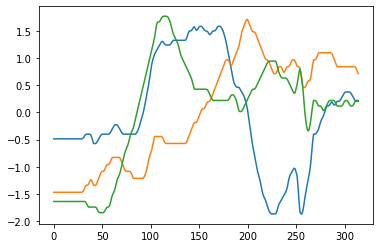

In [104]:
plt.plot(X_test[0].T)
for j in range(3):
    for i in range(len(X_test[0].T)):
#         if mask.reshape(-1,3)[i,j] > 1e-3:
        if j == 0:
            plt.scatter(i,X_test[0].T[i,j],c='red',s=1e3*mask[i,j])
        elif j == 1:
            plt.scatter(i,X_test[0].T[i,j],c='lightgreen',s=1e3*mask[i,j])
        else:
            plt.scatter(i,X_test[0].T[i,j],c='black',s=1e3*mask[i,j])
plt.show()